In [25]:
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Configurar estilo de visualización
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

# Importar módulos de la arquitectura
from config.database import db_config
from utils.data_loader import DataLoader
from utils.preproccesor import DataPreprocessor
from utils.visualization import EducationalVisualizer

print("✅ Módulos importados correctamente")

✅ Módulos importados correctamente


In [26]:
# Conectar a MongoDB
try:
    database = db_config.connect()
    print(f"✅ Conectado a la base de datos: {database.name}")
    
    # Obtener colecciones disponibles
    collections = database.list_collection_names()
    print(f"📚 Colecciones disponibles: {collections}")
    
except Exception as e:
    print(f"❌ Error conectando a la base de datos: {e}")
    # Crear datos de ejemplo para demostración
    print("🔄 Usando datos de ejemplo para demostración")

✅ Conexión exitosa a MongoDB: test
✅ Conectado a la base de datos: test
📚 Colecciones disponibles: ['tutorcodes', 'chatattempts', 'users', 'appointments', 'chathistories', 'conversations', 'chatattemptcounters', 'aiconversations', 'aianalyses', 'posts']


In [27]:
# Configurar fechas para el análisis
end_date = datetime.now()
start_date = end_date - timedelta(days=21)  # Últimos 21 días

print(f"📅 Período de análisis: {start_date.strftime('%Y-%m-%d')} a {end_date.strftime('%Y-%m-%d')}")

# Cargar datos de análisis de IA
try:
    ai_collection = db_config.get_collection('ai_analysis')
    ai_loader = DataLoader(ai_collection)
    ai_data = ai_loader.load_ai_analysis_data(start_date=start_date, end_date=end_date)
    print(f"🤖 Datos de análisis de IA cargados: {len(ai_data)} registros")
except Exception as e:
    print(f"⚠️ No se pudieron cargar datos de IA: {e}")
    ai_data = pd.DataFrame()

📅 Período de análisis: 2025-07-07 a 2025-07-28
⚠️ No se pudieron cargar datos de IA: Database objects do not implement truth value testing or bool(). Please compare with None instead: database is not None


In [28]:
# Cargar datos de citas
try:
    appointments_collection = db_config.get_collection('appointments')
    appointments_loader = DataLoader(appointments_collection)
    appointments_data = appointments_loader.load_appointments_data(start_date=start_date, end_date=end_date)
    print(f"�� Datos de citas cargados: {len(appointments_data)} registros")
except Exception as e:
    print(f"⚠️ No se pudieron cargar datos de citas: {e}")
    appointments_data = pd.DataFrame()

⚠️ No se pudieron cargar datos de citas: Database objects do not implement truth value testing or bool(). Please compare with None instead: database is not None


In [29]:
# Cargar datos de tareas (desde el checklist de citas)
try:
    tasks_data = appointments_loader.load_tasks_data(start_date=start_date, end_date=end_date)
    print(f"📋 Datos de tareas cargados: {len(tasks_data)} registros")
except Exception as e:
    print(f"⚠️ No se pudieron cargar datos de tareas: {e}")
    tasks_data = pd.DataFrame()

⚠️ No se pudieron cargar datos de tareas: name 'appointments_loader' is not defined


In [30]:
rng = np.random.default_rng(46)
limit = 100

# Rango de fechas base (solo días)
start_date = datetime(2025, 6, 20)
end_date = datetime(2025, 6, 27)
days_range = (end_date - start_date).days + 1

# Generar fechas y horas aleatorias
created_at = []
for _ in range(limit):
    # Día aleatorio
    day_offset = rng.integers(0, days_range)
    base_date = start_date + timedelta(days=int(day_offset))
    # Hora, minuto, segundo aleatorio
    hour = rng.integers(0, 24)
    minute = rng.integers(0, 60)
    second = rng.integers(0, 60)
    microsecond = rng.integers(0, 1000) * 1000  # para milisegundos
    dt = base_date.replace(hour=hour, minute=minute, second=second, microsecond=microsecond)
    # Formato ISO 8601 con 'Z'
    created_at.append(dt.strftime('%Y-%m-%dT%H:%M:%S.%f')[:-3] + 'Z')

In [31]:
# Generar datos de ejemplo si no hay datos reales
if ai_data.empty or len(ai_data) <= 30:
    print("...Generando datos de ejemplo para análisis de IA...")

    def get_bullying_explanation(score):
        if score < 0.3:
            return 'Sin bullying detectado'
        elif score < 0.6:
            return 'Posible bullying detectado'
        else:
            return 'Bullying detectado'

    def get_concern_explanation(score):
        if score < 0.3:
            return 'Sin preocupaciones detectadas'
        elif score < 0.6:
            return 'Posible preocupación detectada'
        else:
            return 'Preocupación detectada'

    def get_academic_explanation(score):
        if score < 0.3:
            return 'Conversación poco constructiva'
        elif score < 0.6:
            return 'Conversación medianamente constructiva'
        else:
            return 'Conversación constructiva'

    bullying_scores = rng.uniform(0, 1, len(created_at))
    concern_scores = rng.uniform(0, 1, len(created_at))
    academic_scores = rng.uniform(0, 1, len(created_at))
    
    # Datos de análisis de IA con estructura correcta
    ai_data = pd.DataFrame({
        'created_at': created_at,
        'sender_id': [f'student_{i}' for i in rng.integers(1, 21, size=len(created_at))],
        'recipient_id': [f'tutor_{i}' for i in rng.integers(1, 6, size=len(created_at))],
        'message_content': [f'Mensaje de ejemplo {i}' for i in range(len(created_at))],
        'analysis': [
            {
                'bullying': score,
                'concern': c_score,
                'academic_constructive': a_score,
                'bullying_explanation': get_bullying_explanation(score),
                'concern_explanation': get_concern_explanation(c_score),
                'academic_explanation': get_academic_explanation(a_score)
            }
            for score, c_score, a_score in zip(bullying_scores, concern_scores, academic_scores)
        ]
    })

    ai_data['message_length'] = ai_data['message_content'].str.len()
    
    print(f"✅ Datos de ejemplo generados: {len(ai_data)} registros")

if appointments_data.empty or len(appointments_data) <= 30:
    print("...Generando datos de ejemplo para citas...")
    appointment_dates = created_at
    
    appointments_data = pd.DataFrame({
        'fecha_cita': appointment_dates,
        'id_tutor': [f'tutor_{i}' for i in rng.integers(1, 6, len(appointment_dates))],
        'id_alumno': [f'student_{i}' for i in rng.integers(1, 21, len(appointment_dates))],
        'estado_cita': rng.choice(['pendiente', 'confirmada', 'completada', 'cancelada', 'no_asistio'], len(appointment_dates), p=[0.2, 0.3, 0.3, 0.1, 0.1]),
        'reason': ['Consulta académica'] * len(appointment_dates),
        'checklist': [[{'description': f'Tarea {i}', 'completed': rng.choice([True, False])} for i in range(rng.integers(1, 4))] for _ in range(len(appointment_dates))],
        'created_at': created_at,
        'updated_at': created_at,
    })
    
    print(f"✅ Datos de citas generados: {len(appointments_data)} registros")

if tasks_data.empty or len(tasks_data) <= 30:
    print("...Generando datos de ejemplo para tareas...")
    
    # Extraer tareas del checklist de citas
    tasks_list = []
    for _, appointment in appointments_data.iterrows():
        for task in appointment['checklist']:
            tasks_list.append({
                'appointment_id': f'appointment_{len(tasks_list)}',
                'id_tutor': appointment['id_tutor'],
                'id_alumno': appointment['id_alumno'],
                'fecha_cita': appointment['fecha_cita'],
                'estado_cita': appointment['estado_cita'],
                'task_description': task['description'],
                'task_completed': task['completed']
            })
    
    tasks_data = pd.DataFrame(tasks_list)
    print(f"✅ Datos de tareas generados: {len(tasks_data)} registros")

...Generando datos de ejemplo para análisis de IA...
✅ Datos de ejemplo generados: 100 registros
...Generando datos de ejemplo para citas...
✅ Datos de citas generados: 100 registros
...Generando datos de ejemplo para tareas...
✅ Datos de tareas generados: 190 registros


In [32]:
# Información general de los datasets
print("📊 RESUMEN DE DATOS")
print("=" * 50)

print(f"\n�� ANÁLISIS DE IA:")
print(f"   - Registros: {len(ai_data)}")
if not ai_data.empty:
    print(f"   - Columnas: {list(ai_data.columns)}")
    print(f"   - Período: {ai_data['created_at'].min()} a {ai_data['created_at'].max()}")
    print(f"   - Estudiantes únicos: {ai_data['sender_id'].nunique()}")
    print(f"   - Tutores únicos: {ai_data['recipient_id'].nunique()}")

print(f"\n📅 CITAS:")
print(f"   - Registros: {len(appointments_data)}")
if not appointments_data.empty:
    print(f"   - Columnas: {list(appointments_data.columns)}")
    print(f"   - Período: {appointments_data['fecha_cita'].min()} a {appointments_data['fecha_cita'].max()}")
    print(f"   - Estados: {appointments_data['estado_cita'].value_counts().to_dict()}")

print(f"\n�� TAREAS:")
print(f"   - Registros: {len(tasks_data)}")
if not tasks_data.empty:
    print(f"   - Columnas: {list(tasks_data.columns)}")
    print(f"   - Tasa de completado: {tasks_data['task_completed'].mean():.2%}")
    print(f"   - Tareas por cita: {len(tasks_data) / len(appointments_data):.1f}")

📊 RESUMEN DE DATOS

�� ANÁLISIS DE IA:
   - Registros: 100
   - Columnas: ['created_at', 'sender_id', 'recipient_id', 'message_content', 'analysis', 'message_length']
   - Período: 2025-06-20T00:10:31.652Z a 2025-06-27T18:42:07.351Z
   - Estudiantes únicos: 20
   - Tutores únicos: 5

📅 CITAS:
   - Registros: 100
   - Columnas: ['fecha_cita', 'id_tutor', 'id_alumno', 'estado_cita', 'reason', 'checklist', 'created_at', 'updated_at']
   - Período: 2025-06-20T00:10:31.652Z a 2025-06-27T18:42:07.351Z
   - Estados: {'confirmada': 27, 'completada': 22, 'pendiente': 22, 'no_asistio': 15, 'cancelada': 14}

�� TAREAS:
   - Registros: 190
   - Columnas: ['appointment_id', 'id_tutor', 'id_alumno', 'fecha_cita', 'estado_cita', 'task_description', 'task_completed']
   - Tasa de completado: 52.63%
   - Tareas por cita: 1.9


In [33]:
appointments_data['fecha_cita'] = pd.to_datetime(appointments_data['fecha_cita'])
appointments_data['created_at'] = pd.to_datetime(appointments_data['created_at'])

# Inicializar preprocesador
preprocessor = DataPreprocessor()

# Limpiar datos de análisis de IA
if not ai_data.empty:
    print("...Limpiando datos de análisis de IA...")
    ai_data['created_at'] = pd.to_datetime(ai_data['created_at'])
    ai_clean = preprocessor.clean_ai_analysis_data(ai_data)
    print(f"   - Registros originales: {len(ai_data)}")
    print(f"   - Registros limpios: {len(ai_clean)}")
    
    # Crear features adicionales
    ai_features = preprocessor.create_time_series_features(ai_clean, 'created_at')
    print(f"   - Features creados: {list(ai_features.columns)}")
else:
    ai_clean = pd.DataFrame()
    ai_features = pd.DataFrame()

# Limpiar datos de citas
if not appointments_data.empty:
    print("\n...Limpiando datos de citas...")
    appointments_clean = preprocessor.clean_appointments_data(appointments_data)
    print(f"   - Registros originales: {len(appointments_data)}")
    print(f"   - Registros limpios: {len(appointments_clean)}")
else:
    appointments_clean = pd.DataFrame()

# Limpiar datos de tareas
if not tasks_data.empty:
    print("\n�� Limpiando datos de tareas...")
    tasks_clean = preprocessor.clean_tasks_data(tasks_data)
    print(f"   - Registros originales: {len(tasks_data)}")
    print(f"   - Registros limpios: {len(tasks_clean)}")
else:
    tasks_clean = pd.DataFrame()

...Limpiando datos de análisis de IA...
   - Registros originales: 100
   - Registros limpios: 100
   - Features creados: ['created_at', 'sender_id', 'recipient_id', 'message_content', 'analysis', 'message_length', 'bullying', 'concern', 'academic_constructive', 'hour', 'day_of_week', 'month', 'is_weekend', 'year', 'day', 'day_of_year', 'week_of_year', 'month_sin', 'month_cos', 'day_of_week_sin', 'day_of_week_cos', 'hour_sin', 'hour_cos', 'is_business_hour', 'is_morning', 'is_afternoon', 'is_evening', 'is_night']

...Limpiando datos de citas...
   - Registros originales: 100
   - Registros limpios: 100

�� Limpiando datos de tareas...
   - Registros originales: 190
   - Registros limpios: 190


In [34]:
print("Columnas en ai_clean:", ai_clean.columns.tolist())
print(ai_clean.dtypes)

Columnas en ai_clean: ['created_at', 'sender_id', 'recipient_id', 'message_content', 'analysis', 'message_length', 'bullying', 'concern', 'academic_constructive', 'hour', 'day_of_week', 'month', 'is_weekend']
created_at               datetime64[ns, UTC]
sender_id                             object
recipient_id                          object
message_content                       object
analysis                              object
message_length                         int64
bullying                             float64
concern                              float64
academic_constructive                float64
hour                                   int32
day_of_week                            int32
month                                  int32
is_weekend                              bool
dtype: object


In [35]:
print(ai_clean[['created_at', 'bullying', 'concern', 'academic_constructive', 'message_length']].head(10))

                        created_at  bullying   concern  academic_constructive  \
0 2025-06-24 21:13:04.549000+00:00  0.942783  0.039220               0.432799   
1 2025-06-22 05:37:08.934000+00:00  0.347106  0.741950               0.949302   
2 2025-06-26 02:45:37.808000+00:00  0.282642  0.654630               0.695700   
3 2025-06-26 05:30:27.748000+00:00  0.800357  0.322494               0.890902   
4 2025-06-25 21:34:29.515000+00:00  0.350079  0.896866               0.958128   
5 2025-06-26 18:03:37.730000+00:00  0.334913  0.404756               0.247240   
6 2025-06-21 18:47:03.931000+00:00  0.766630  0.808401               0.236952   
7 2025-06-20 05:23:16.326000+00:00  0.908887  0.120913               0.012996   
8 2025-06-26 06:19:50.963000+00:00  0.377197  0.645680               0.923694   
9 2025-06-20 05:10:20.638000+00:00  0.509952  0.673473               0.904271   

   message_length  
0              20  
1              20  
2              20  
3              20  
4       

In [36]:
print(ai_clean[['bullying', 'concern', 'academic_constructive', 'message_length']].describe())

         bullying     concern  academic_constructive  message_length
count  100.000000  100.000000             100.000000      100.000000
mean     0.506301    0.503744               0.491910       20.900000
std      0.284727    0.304132               0.312597        0.301511
min      0.006905    0.007677               0.003518       20.000000
25%      0.277668    0.224845               0.200524       21.000000
50%      0.478636    0.532982               0.474740       21.000000
75%      0.758797    0.776379               0.799766       21.000000
max      0.995608    0.998006               0.983587       21.000000


In [37]:
print("Valores nulos por columna:")
print(ai_clean[['bullying', 'concern', 'academic_constructive']].isnull().sum())

print("Valores únicos por columna:")
print(ai_clean[['bullying', 'concern', 'academic_constructive']].nunique())

Valores nulos por columna:
bullying                 0
concern                  0
academic_constructive    0
dtype: int64
Valores únicos por columna:
bullying                 100
concern                  100
academic_constructive    100
dtype: int64


In [38]:
print("Valores únicos de bullying:", ai_clean['bullying'].unique())
print("Valores únicos de concern:", ai_clean['concern'].unique())
print("Valores únicos de academic_constructive:", ai_clean['academic_constructive'].unique())

Valores únicos de bullying: [0.94278329 0.34710585 0.28264177 0.80035655 0.35007928 0.33491331
 0.76662996 0.90888707 0.37719689 0.50995193 0.47821007 0.39965279
 0.27011728 0.13865919 0.6078987  0.13266344 0.84053879 0.68276573
 0.38574721 0.69402799 0.84734986 0.23513376 0.82425252 0.57359175
 0.30832149 0.26636799 0.8950151  0.40083154 0.89138235 0.16683632
 0.71919225 0.79440632 0.08674389 0.43151181 0.04541571 0.21100236
 0.30032895 0.52728943 0.29418567 0.26489207 0.57644123 0.64014914
 0.63735193 0.91035601 0.52835296 0.31288216 0.39634062 0.28018515
 0.18292533 0.65213541 0.36854246 0.87363959 0.94120008 0.46391543
 0.47906138 0.11138963 0.73676241 0.86806815 0.33908612 0.14721176
 0.11464821 0.20222296 0.39125757 0.69523269 0.62433113 0.19142092
 0.25949083 0.98172083 0.71914097 0.76127901 0.67712192 0.12098925
 0.54069195 0.75796993 0.20664722 0.87037151 0.00690512 0.82624409
 0.90775073 0.31362407 0.93842855 0.99560844 0.10603403 0.44162592
 0.51543892 0.89863349 0.02875689 

In [39]:
print(ai_clean[(ai_clean['bullying'] == 0) & (ai_clean['concern'] == 0) & (ai_clean['academic_constructive'] == 0)].shape)
print(ai_clean[(ai_clean['bullying'].isnull()) | (ai_clean['concern'].isnull()) | (ai_clean['academic_constructive'].isnull())].shape)

(0, 13)
(0, 13)


In [40]:
print(ai_clean['created_at'].dt.date.value_counts().sort_index())

created_at
2025-06-20    14
2025-06-21    14
2025-06-22     8
2025-06-23    21
2025-06-24    11
2025-06-25    13
2025-06-26    12
2025-06-27     7
Name: count, dtype: int64


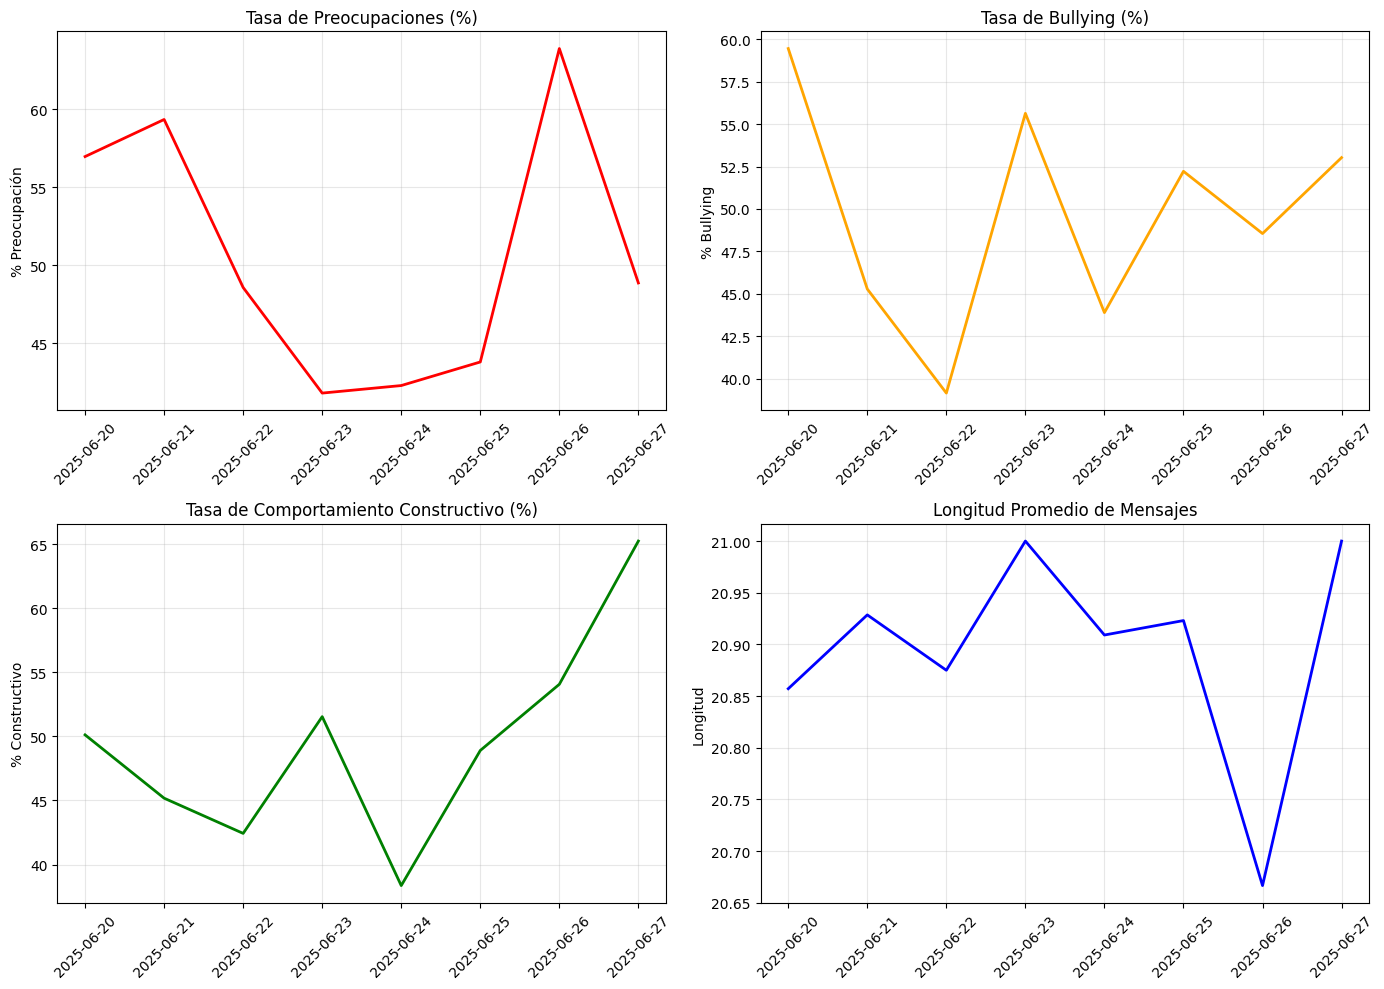

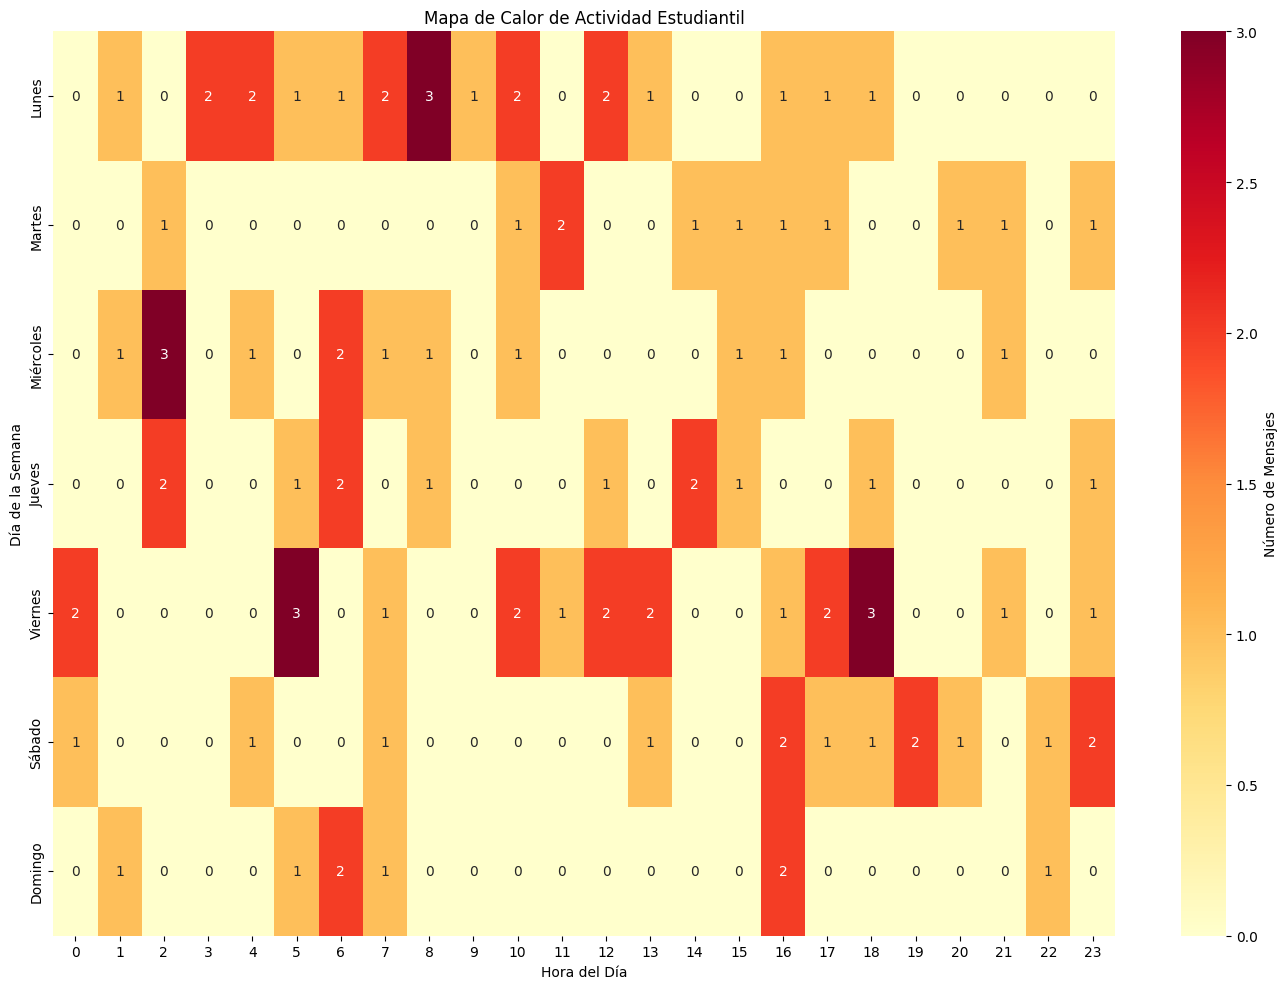

In [41]:
edu_viz = EducationalVisualizer(figsize=(14, 10))

# Tendencias de engagement (requiere: 'created_at', 'concern', 'bullying', 'academic_constructive', 'message_length')
edu_viz.plot_engagement_trends(ai_clean, date_column='created_at')

# Mapa de calor de actividad estudiantil por hora y día
edu_viz.plot_student_activity_heatmap(ai_clean)

,created_at,sender_id,recipient_id,message_content,analysis,message_length,bullying,concern,academic_constructive,hour,day_of_week,month,is_weekend
count,100,100,100,100,100,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.0,100
unique,NaN,20,5,100,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,NaN,student_10,tutor_5,Mensaje de ejemplo 0,"{'bullying': 0.9427832903751258, 'concern': 0....",NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
freq,NaN,9,25,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78
mean,2025-06-23 17:05:28.538109952+00:00,NaN,NaN,NaN,NaN,20.900000,0.506301,0.503744,0.491910,11.130000,2.750000,6.0,NaN
min,2025-06-20 00:10:31.652000+00:00,NaN,NaN,NaN,NaN,20.000000,0.006905,0.007677,0.003518,0.000000,0.000000,6.0,NaN
25%,2025-06-21 21:48:09.595249920+00:00,NaN,NaN,NaN,NaN,21.000000,0.277668,0.224845,0.200524,6.000000,1.000000,6.0,NaN
50%,2025-06-23 10:21:14.298499840+00:00,NaN,NaN,NaN,NaN,21.000000,0.478636,0.532982,0.474740,11.000000,3.000000,6.0,NaN
75%,2025-06-25 06:54:36.444250112+00:00,NaN,NaN,NaN,NaN,21.000000,0.758797,0.776379,0.799766,16.250000,4.000000,6.0,NaN
max,2025-06-27 18:42:07.351000+00:00,NaN,NaN,NaN,NaN,21.000000,0.995608,0.998006,0.983587,23.000000,6.000000,6.0,NaN


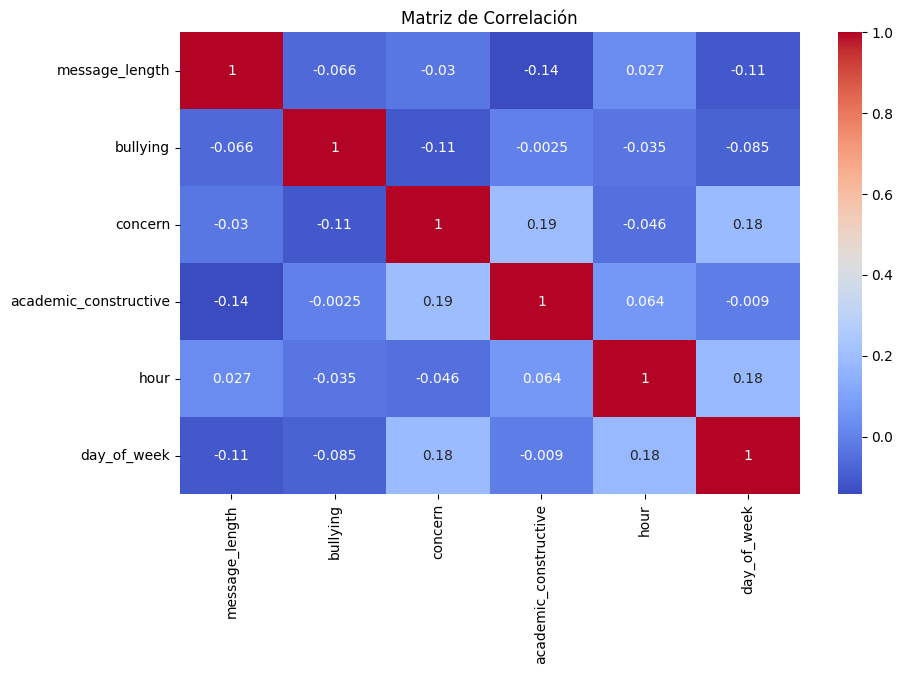

In [42]:
# Estadísticas descriptivas rápidas
display(ai_clean.describe(include='all'))
ai_clean_copy = ai_clean.drop(columns=['month']).copy()

# Matriz de correlación para variables numéricas
plt.figure(figsize=(10, 6))
sns.heatmap(ai_clean_copy.select_dtypes(include='number').corr(), annot=True, cmap='coolwarm')
plt.title("Matriz de Correlación")
plt.show()

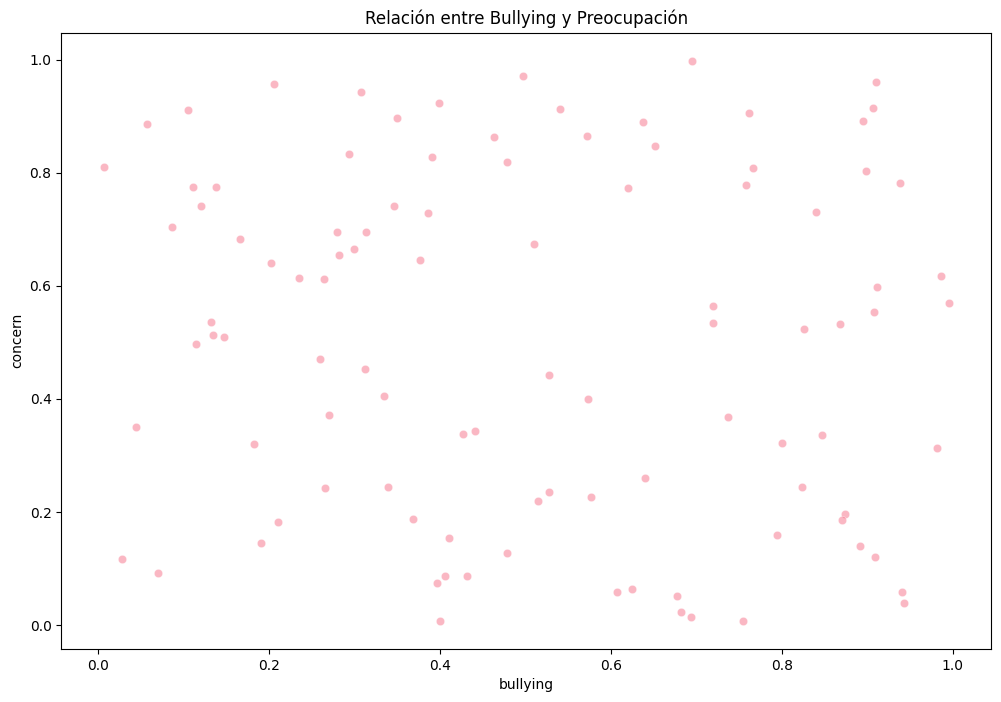

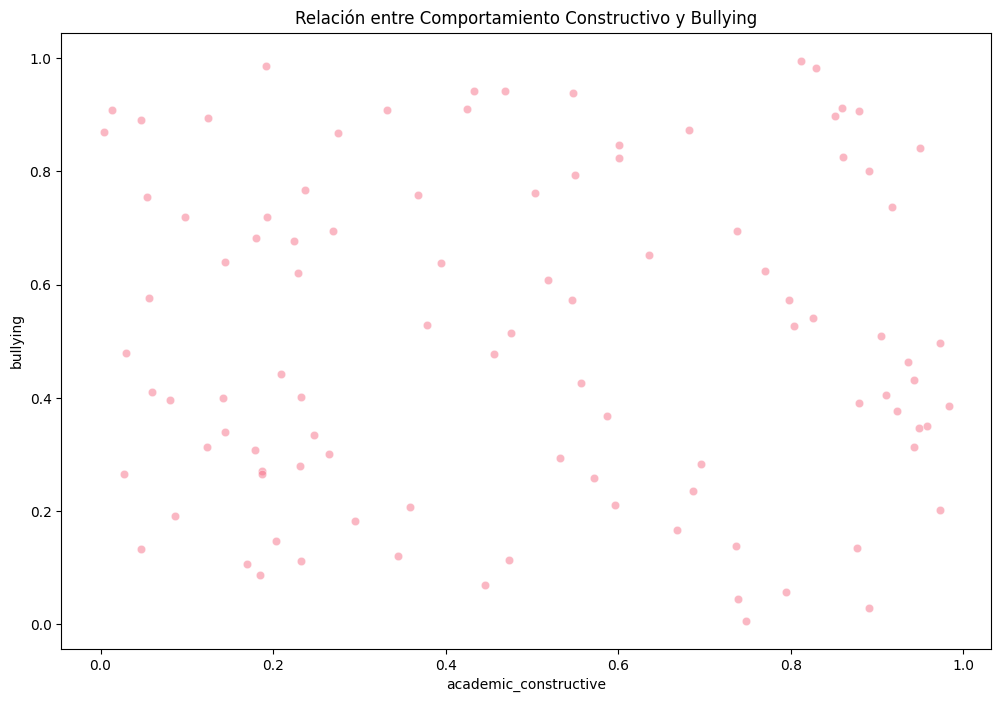

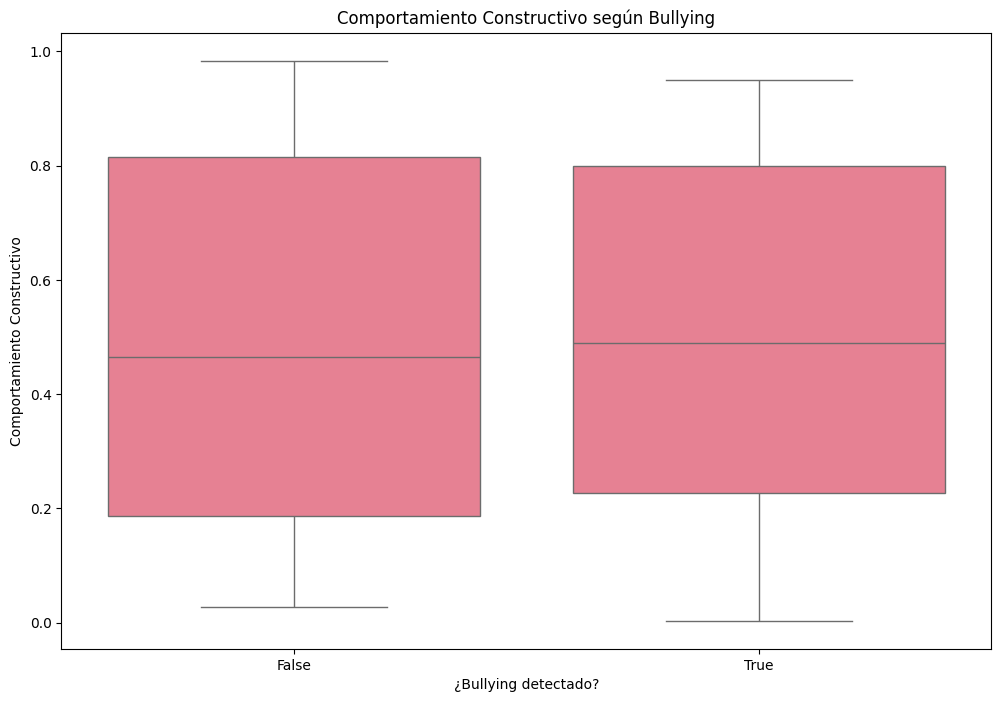

In [43]:
# Relación entre bullying y concern
sns.scatterplot(data=ai_clean, x='bullying', y='concern', alpha=0.5)
plt.title("Relación entre Bullying y Preocupación")
plt.show()

# Relación entre academic_constructive y bullying
sns.scatterplot(data=ai_clean, x='academic_constructive', y='bullying', alpha=0.5)
plt.title("Relación entre Comportamiento Constructivo y Bullying")
plt.show()

# Boxplot de academic_constructive por presencia de bullying
ai_clean['bullying_flag'] = ai_clean['bullying'] > 0.5
sns.boxplot(data=ai_clean, x='bullying_flag', y='academic_constructive')
plt.title("Comportamiento Constructivo según Bullying")
plt.xlabel("¿Bullying detectado?")
plt.ylabel("Comportamiento Constructivo")
plt.show()

In [44]:
print(appointments_clean.columns)
print(appointments_clean['days_to_appointment'].head())
print(appointments_clean['days_to_appointment'].dropna().shape)

Index(['fecha_cita', 'id_tutor', 'id_alumno', 'estado_cita', 'reason',
       'checklist', 'created_at', 'updated_at', 'days_to_appointment'],
      dtype='object')
0    0
1    0
2    0
3    0
4    0
Name: days_to_appointment, dtype: int64
(100,)


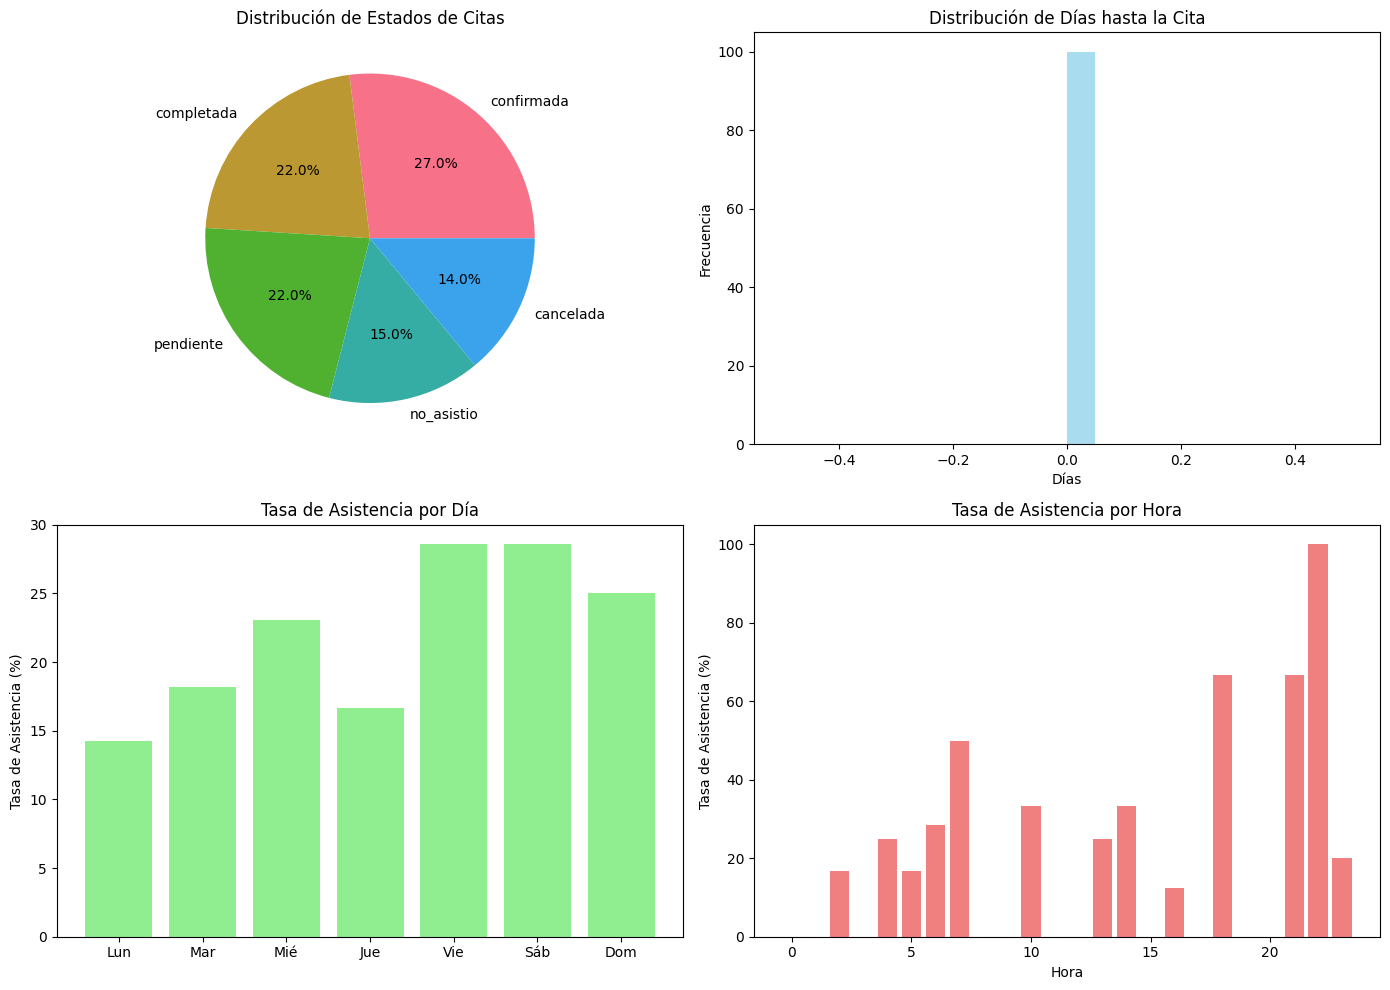

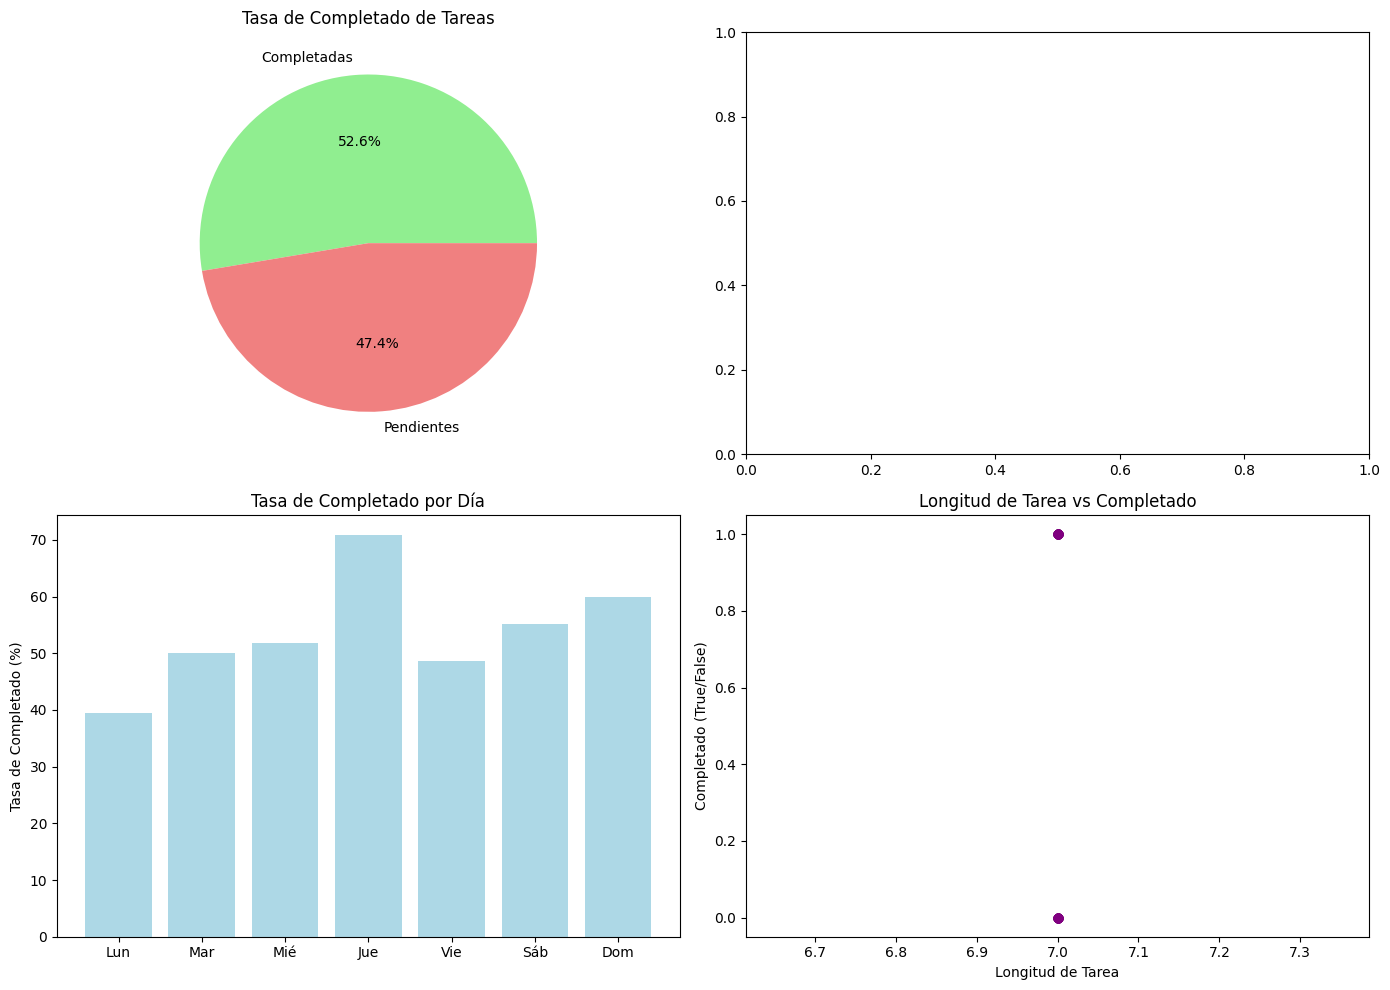

In [45]:
# Análisis de citas
edu_viz.plot_appointment_analysis(appointments_clean)

tasks_clean['fecha_cita'] = pd.to_datetime(tasks_clean['fecha_cita'])
# Análisis de tareas
edu_viz.plot_task_completion_analysis(tasks_clean)

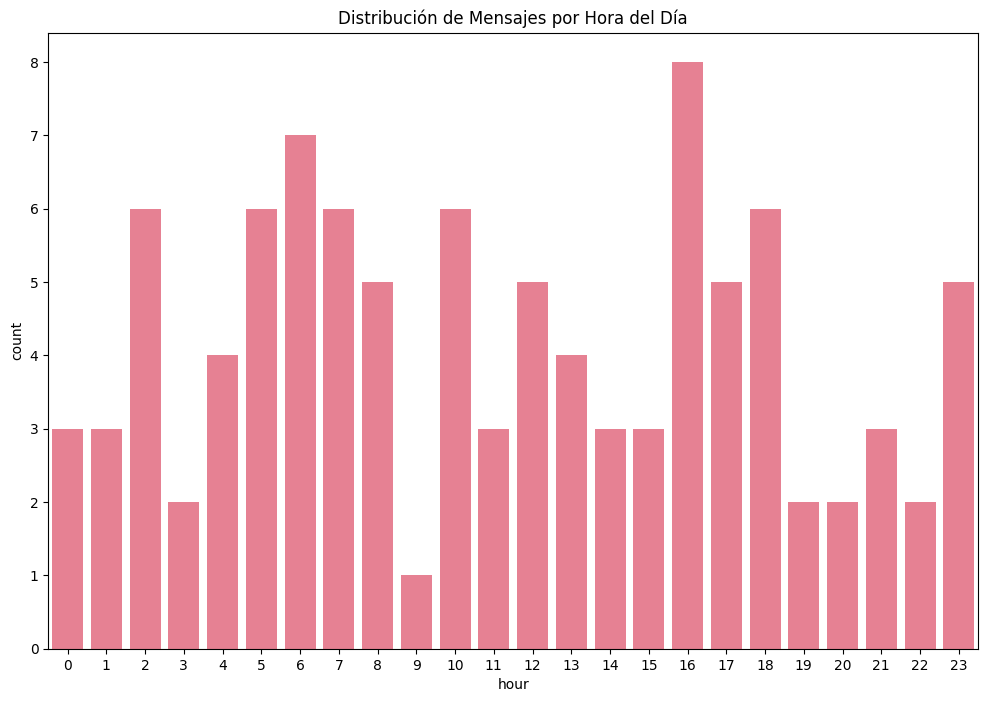

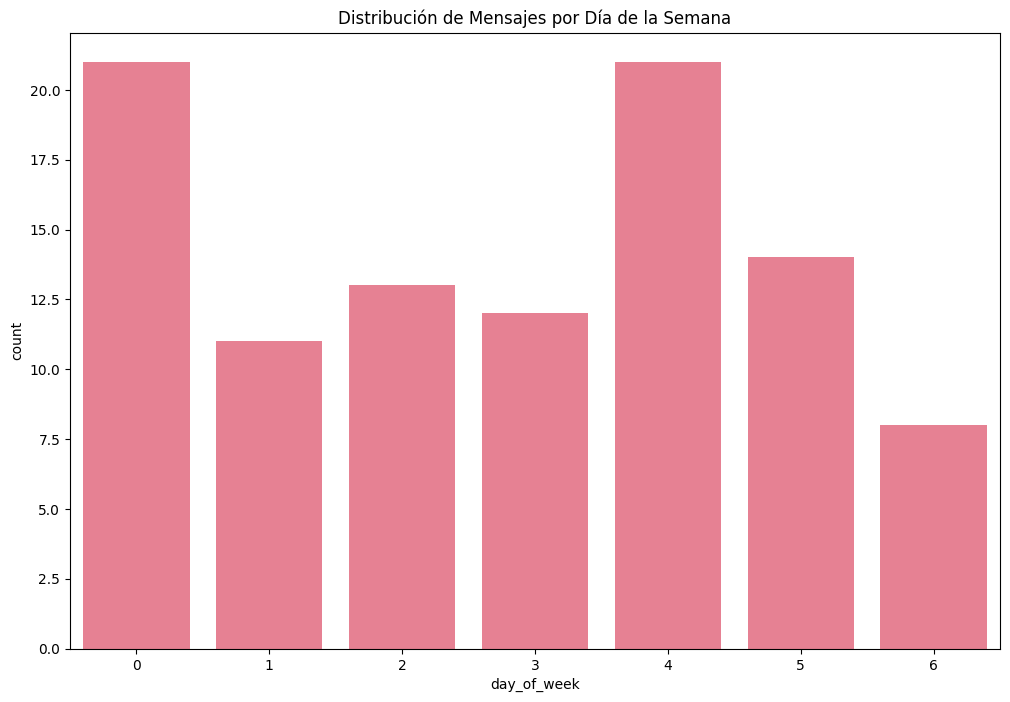

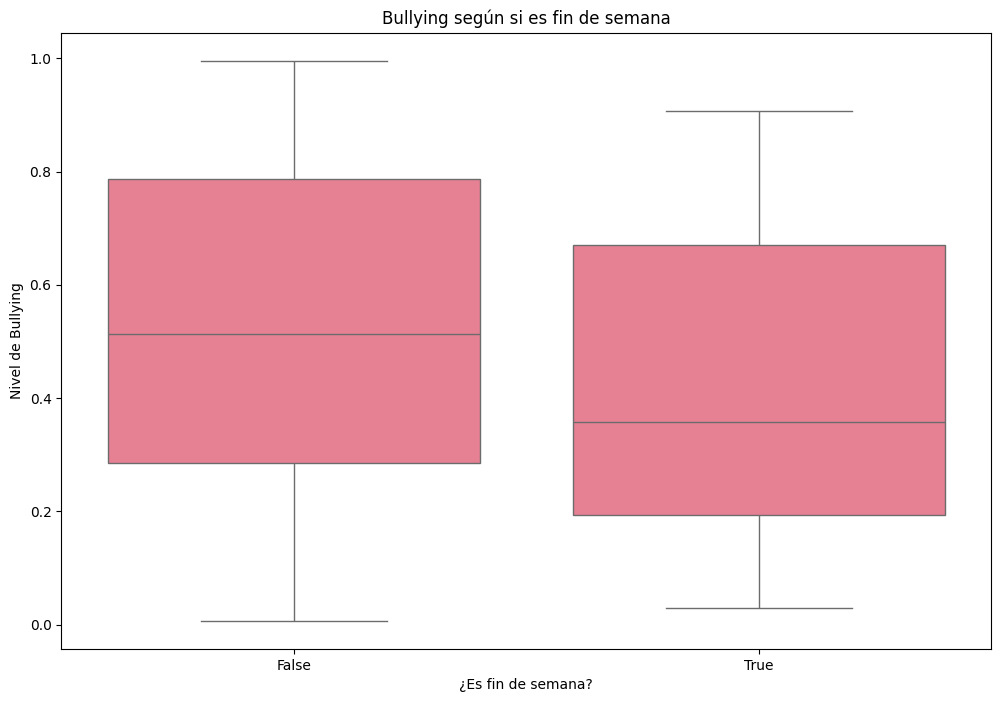

In [46]:
# Distribución de mensajes por hora del día
sns.countplot(data=ai_clean, x='hour')
plt.title("Distribución de Mensajes por Hora del Día")
plt.show()

# Distribución de mensajes por día de la semana
sns.countplot(data=ai_clean, x='day_of_week')
plt.title("Distribución de Mensajes por Día de la Semana")
plt.show()

# ¿Hay más bullying en fines de semana?
sns.boxplot(data=ai_clean, x='is_weekend', y='bullying')
plt.title("Bullying según si es fin de semana")
plt.xlabel("¿Es fin de semana?")
plt.ylabel("Nivel de Bullying")
plt.show()

In [47]:
# Tasa de completado de tareas por día de la semana
if 'day_of_week' in tasks_clean.columns:
    sns.barplot(data=tasks_clean, x='day_of_week', y='task_completed')
    plt.title("Tasa de Completado de Tareas por Día de la Semana")
    plt.show()

In [48]:
import os

# Ruta base donde se encuentra ai_clean.csv
ruta_base = os.path.dirname('data')

# Guardar los DataFrames limpios
appointments_clean.to_csv(os.path.join(ruta_base, 'appointments_clean.csv'), index=False)
tasks_clean.to_csv(os.path.join(ruta_base, 'tasks_clean.csv'), index=False)
ai_clean.to_csv(os.path.join(ruta_base, 'ai_clean.csv'), index=False)

print("✅ Archivos guardados en la carpeta /data:")
print(" - appointments_clean.csv")
print(" - tasks_clean.csv")
print(" - ai_clean.csv")

✅ Archivos guardados en la carpeta /data:
 - appointments_clean.csv
 - tasks_clean.csv
 - ai_clean.csv
